# Multi variable networks

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 

from numpy.lib.stride_tricks import sliding_window_view

import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
df = pd.read_csv('GOOGL.csv')
df.Date = pd.to_numeric(pd.to_datetime(df.Date, format='%Y-%m-%d'))
df.pop('Adj Close')

0         50.220219
1         54.209209
2         54.754753
3         52.487488
4         53.053055
           ...     
4426    2722.510010
4427    2722.030029
4428    2797.360107
4429    2765.510010
4430    2831.439941
Name: Adj Close, Length: 4431, dtype: float64

In [62]:
df.describe()

,Date,Open,High,Low,Close,Volume
count,4.431000e+03,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,1.370505e+18,693.087345,699.735595,686.078751,693.097367,6.444992e+06
std,1.603781e+17,645.118799,651.331215,638.579488,645.187806,7.690351e+06
min,1.092874e+18,49.644646,50.920921,48.028027,50.055054,4.656000e+05
25%,1.231762e+18,248.558563,250.853355,245.813309,248.415916,1.695600e+06
50%,1.370563e+18,434.924927,437.887878,432.687683,435.330322,3.778418e+06
75%,1.509192e+18,1007.364990,1020.649994,997.274994,1007.790008,8.002390e+06
max,1.648080e+18,3025.000000,3030.929932,2977.979980,2996.770020,8.215117e+07


## Setup

In [92]:
def prepare_data_partial(data, scaler, window_size=50, train=True):
    scaled_data = scaler.fit_transform(data) if train else scaler.transform(data)
    input_data = sliding_window_view(scaled_data, window_size, axis=0).transpose(0,2,1)[:-1]
    output_data = scaled_data[window_size:,1]
    output_data = np.reshape(output_data, (-1,1))
    return (input_data, output_data)
    
def prepare_data(data, scaler, split=0.9, window_size=50):
    train_size = int(split*len(data))
    
    train = data[:train_size]
    test = data[train_size:]
    
    preped_train = prepare_data_partial(train, scaler, window_size, True)
    preped_test = prepare_data_partial(test, scaler, window_size, True)
    return (preped_train, preped_test)

In [158]:
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()
hub = keras.losses.Huber()
hin = keras.losses.Hinge()

def eval_model(model, history, loss='mae', optimizer='AdamW'):
    y_pred = model.predict(X_test)
    res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
    sns.lineplot(res, dashes=False)
    plt.show()
    
    pd.DataFrame(history.history).plot()
    plt.show()

    #print(f"Best val loss: {min(history.history['val_loss'])}")
    
    return {
        'best_val_loss': min(history.history['val_loss']),
        'loss_method': loss,
        'optimizer': optimizer,
        'mae': mae(y_test, y_pred).numpy(),
        'mse': mse(y_test, y_pred).numpy(),
        'huber': hub(y_test, y_pred).numpy(),
        'hinge': hin(y_test, y_pred).numpy(),
    }

def res_to_table(result):
    return pd.DataFrame.from_dict(result, orient='index').T

In [120]:
results = {}

In [ ]:
scaler = MinMaxScaler((-1,1))
data = np.array(df)
((X_train, y_train), (X_test, y_test)) = prepare_data(data, scaler)

## SimpleRNN

### 1 SimpleRNN sloj

In [109]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 50)                2850      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 20ms/step - loss: 0.0428 - val_loss: 0.0469 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 18ms/step - loss: 0.0038 - val_loss: 0.0355 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0116 - lr: 0.0010
Epoch 4/300
25/25 [==============================] - 0s 17ms/step - loss: 9.4

13/13 [==============================] - 0s 4ms/step


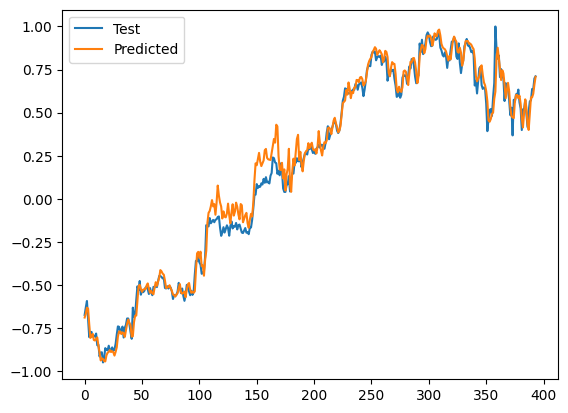

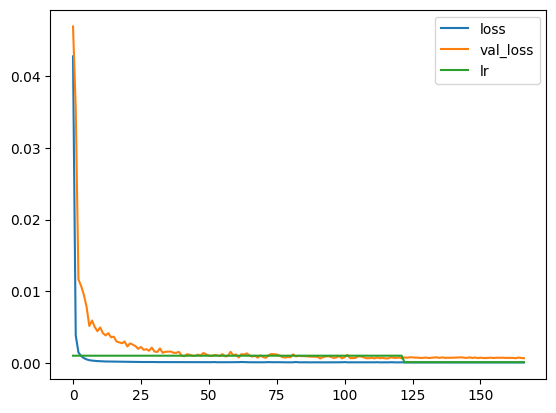

Best val loss: 0.0006122486083768308


,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000612,mae,AdamW,0.047369,0.004425,0.002213,0.634505


In [141]:
results['SimpleRNN_1layer'] = eval_model(model, history)
res_to_table(results['SimpleRNN_1layer'])

In [151]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, 50, 50)            2850      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 7951 (31.06 KB)
Trainable params: 7951 (31.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 3s 49ms/step - loss: 0.0310 - val_loss: 0.0114 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 1s 40ms/step - loss: 0.0022 - val_loss: 0.0064 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 1s 4

13/13 [==============================] - 0s 7ms/step


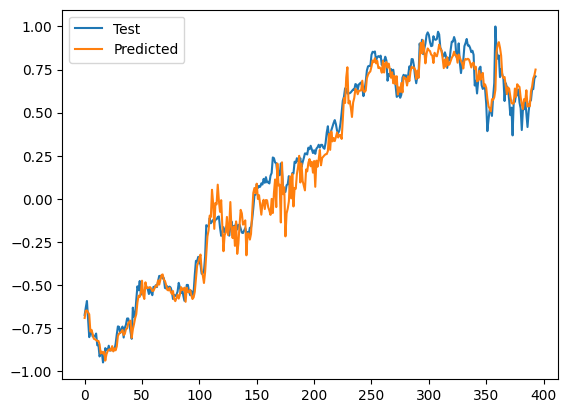

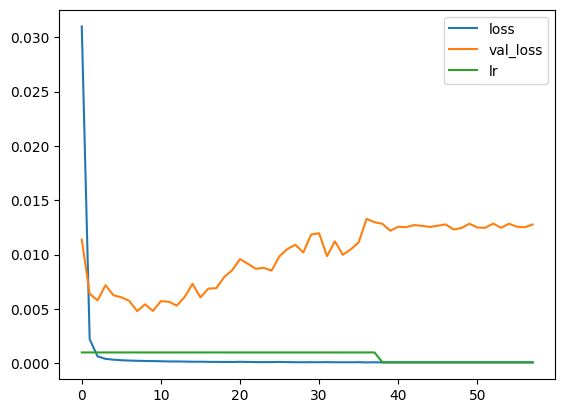

Best val loss: 0.004806699231266975


,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.004807,mae,AdamW,0.061954,0.006845,0.003422,0.647845


In [152]:
results['SimpleRNN_2layer'] = eval_model(model, history)
res_to_table(results['SimpleRNN_2layer'])

## LSTM

In [156]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 800
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                11400     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 17ms/step - loss: 0.0716 - val_loss: 0.0710 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0501 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0447 - lr: 0.0010
Epoch 4/800
25/25 [==============================] - 0s 4ms/step - loss: 8.2

13/13 [==============================] - 0s 2ms/step


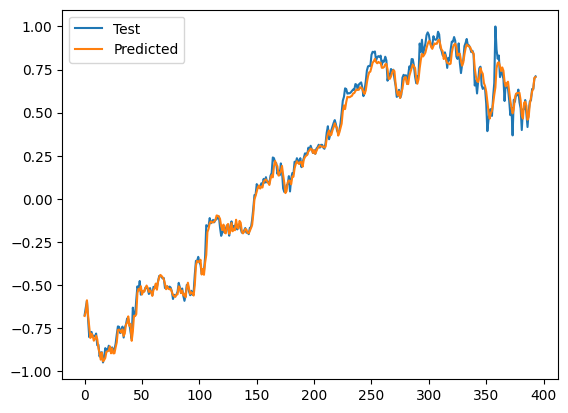

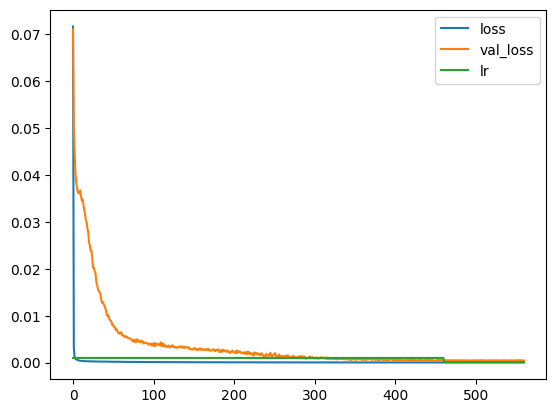

Best val loss: 0.00042842456605285406


,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000428,mae,AdamW,0.027784,0.00172,0.00086,0.643248


In [157]:
results['LSTM_1layer'] = eval_model(model, history)
res_to_table(results['LSTM_1layer'])

### 2 LSTM sloja

In [161]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 800
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50, 50)            11400     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 31651 (123.64 KB)
Trainable params: 31651 (123.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 3s 27ms/step - loss: 0.0288 - val_loss: 0.0293 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0168 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0

13/13 [==============================] - 0s 2ms/step


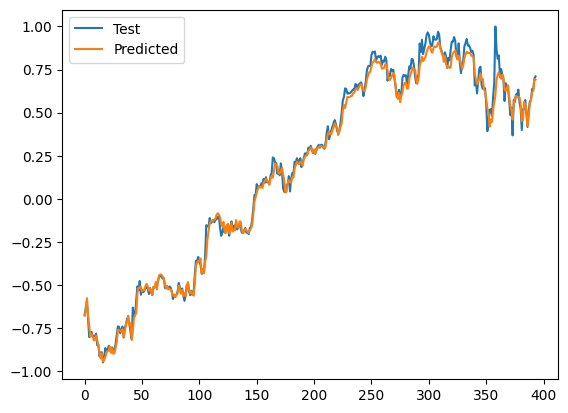

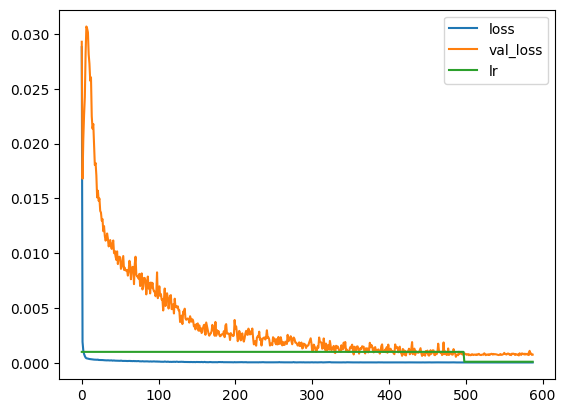

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.00055,mae,AdamW,0.0299,0.001996,0.000998,0.649121


In [162]:
results['LSTM_2layer'] = eval_model(model, history)
res_to_table(results['LSTM_2layer'])

## GRU

In [165]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])

epochs = 600
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/600
25/25 [==============================] - 2s 15ms/step - loss: 0.0139 - val_loss: 0.0509 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0116 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 4ms/step - loss: 7.3902e-04 - val_loss: 0.0104 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 4ms/step - loss: 3.8581e-04 - val_loss: 0.0047 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 4ms/step - loss: 2.1069e-04 - val_loss: 0.0026 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 4ms/step - loss: 1.3408e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 5ms/step - loss: 1.0674e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 4ms/step - loss: 9.6520e-05 - val_loss: 0.0013 - lr: 0.0010
Epoch 9/600
25/25 [==============================] - 0s 5ms/step - loss: 9.1230

13/13 [==============================] - 0s 1ms/step


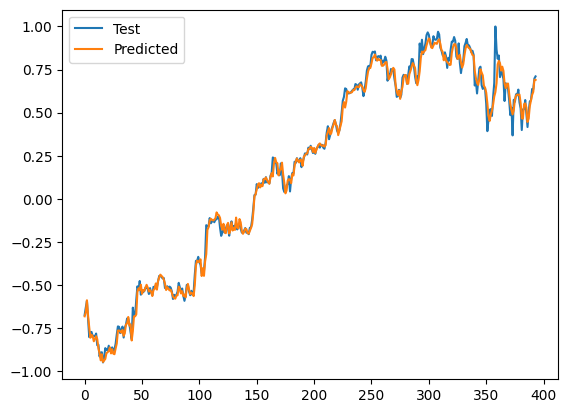

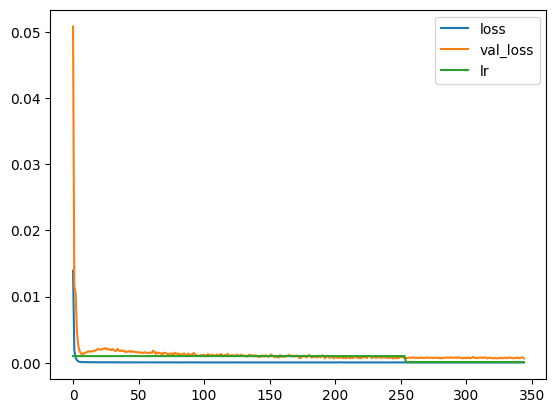

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000617,mae,AdamW,0.025852,0.001678,0.000839,0.642022


In [166]:
results['GRU_1layer'] = eval_model(model, history)
res_to_table(results['GRU_1layer'])

### 2 GRU sloja

In [167]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])

epochs = 600
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/600
25/25 [==============================] - 3s 24ms/step - loss: 0.0831 - val_loss: 0.0070 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0278 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0082 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 7ms/step - loss: 5.6704e-04 - val_loss: 0.0045 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 6ms/step - loss: 2.9548e-04 - val_loss: 0.0021 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 9ms/step - loss: 1.9832e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 6ms/step - loss: 1.7202e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 6ms/step - loss: 1.6519e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 9/600
25/25 [==============================] - 0s 6ms/step - loss: 1.5910e-04

13/13 [==============================] - 0s 2ms/step


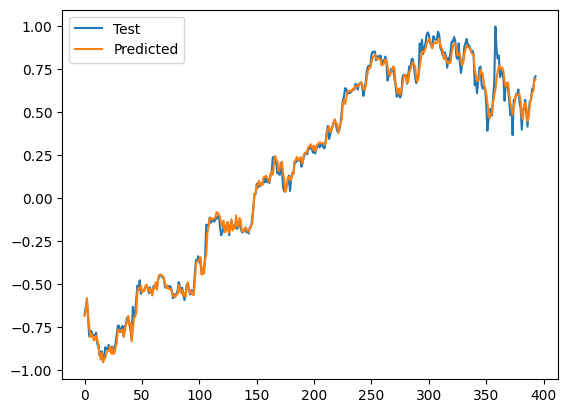

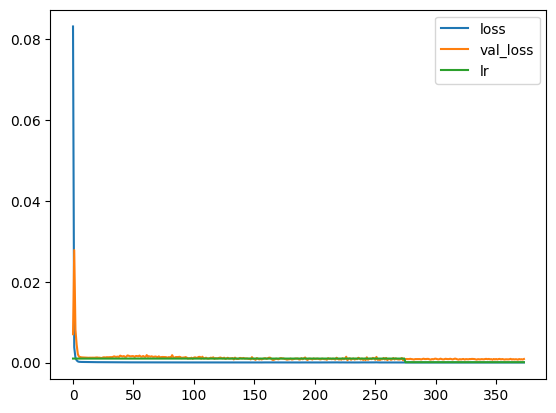

,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,0.000574,mae,AdamW,0.02525,0.00159,0.000795,0.640001


In [168]:
results['GRU_2layer'] = eval_model(model, history)
res_to_table(results['GRU_2layer'])

## Poredjenje

In [234]:
res = res_to_table(results).T.reset_index(names='type')
res

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,SimpleRNN_1layer,0.000612,mae,AdamW,0.047369,0.004425,0.002213,0.634505
1,SimpleRNN_2layer,0.004807,mae,AdamW,0.061954,0.006845,0.003422,0.647845
2,LSTM_1layer,0.000428,mae,AdamW,0.027784,0.00172,0.00086,0.643248
3,LSTM_2layer,0.00055,mae,AdamW,0.0299,0.001996,0.000998,0.649121
4,GRU_1layer,0.000617,mae,AdamW,0.025852,0.001678,0.000839,0.642022
5,GRU_2layer,0.000574,mae,AdamW,0.02525,0.00159,0.000795,0.640001


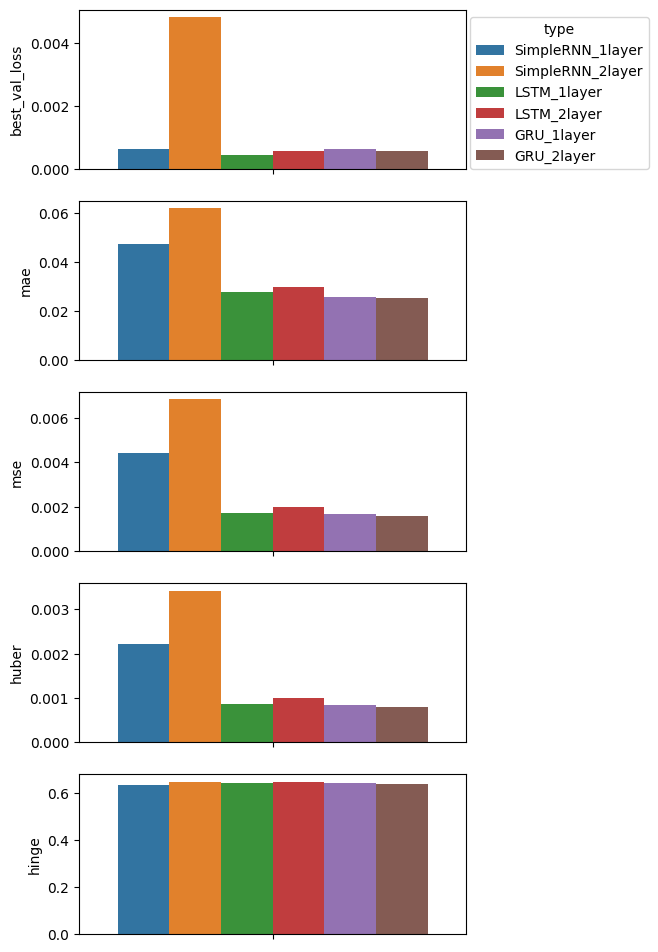

In [257]:
fig = plt.figure(figsize=(5,12))
axs = fig.subplots(nrows=5)
for i, col in enumerate(['best_val_loss', 'mae', 'mse', 'huber', 'hinge']):
    if i == 0:
        sns.move_legend(sns.barplot(res, hue='type', y=col, ax=axs[i], legend=True), (1.01,0))
    else:
        sns.barplot(res, hue='type', y=col, ax=axs[i], legend=False)

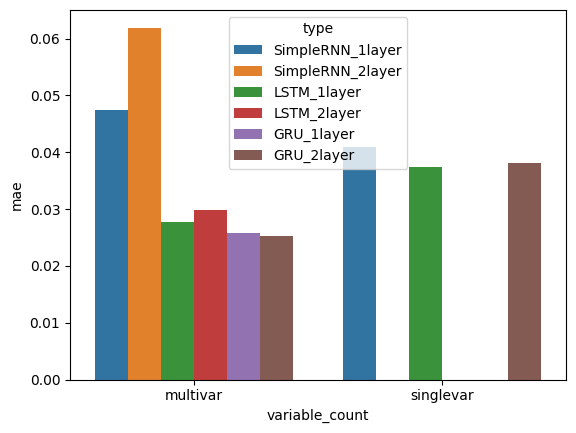

In [236]:
singlevar = pd.read_csv('./data/singlevar_metrics.csv', names=['type', 'mae', 'mse', 'rmse'])[1:]
singlevar['variable_count'] = 'singlevar'
singlevar['type'] = singlevar['type'].map({'SimpleRNN': 'SimpleRNN_1layer', 'GRU': 'GRU_2layer', 'LSTM': 'LSTM_1layer'})
res['variable_count'] = 'multivar'
res2 = pd.concat([res, singlevar])
g = sns.barplot(res2, x='variable_count', y='mae', hue='type')
g.invert_yaxis()

In [259]:
res.to_csv('./data/multivar.csv')